In [ ]:
from google.colab import files
uploaded = files.upload()

Saving df_train.csv to df_train.csv
Saving df_forecast.csv to df_forecast.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
# 读取数据
df_train = pd.read_csv(
    "df_train.csv",
    index_col=0,
    parse_dates=True
)

df_train.head()


,WaterLevel(m),Flow(L/s),Velocity(m/s),WaterTemperature(_),Precipiation(mm),AirTemperature(_),RelativeHumidity(%),VaporPressure(kPa),WindSpeed(m/s),WindDirection
Datetime,,,,,,,,,,
2022-10-01 00:00:00,1.364,176.934,0.352,22.882,0.0,21.4,83.0,1007.0,0.0,0.0
2022-10-01 00:01:00,1.364,186.988,0.372,22.882,0.0,21.4,83.0,1007.0,0.0,0.0
2022-10-01 00:02:00,1.364,181.961,0.362,22.882,0.0,21.4,83.0,1007.0,0.0,0.0
2022-10-01 00:03:00,1.364,176.934,0.352,22.882,0.0,21.4,83.0,1007.0,0.0,0.0
2022-10-01 00:04:00,1.364,186.988,0.372,22.882,0.0,21.4,83.0,1007.0,0.0,0.0


In [ ]:
# 时间范围检查
print(df_train.index.min(), df_train.index.max())

# 缺失值检查
df_train.isna().sum()


2022-10-01 00:00:00 2022-11-11 23:59:00


,0
WaterLevel(m),0
Flow(L/s),0
Velocity(m/s),0
WaterTemperature(_),0
Precipiation(mm),0
AirTemperature(_),0
RelativeHumidity(%),0
VaporPressure(kPa),0
WindSpeed(m/s),0
WindDirection,0


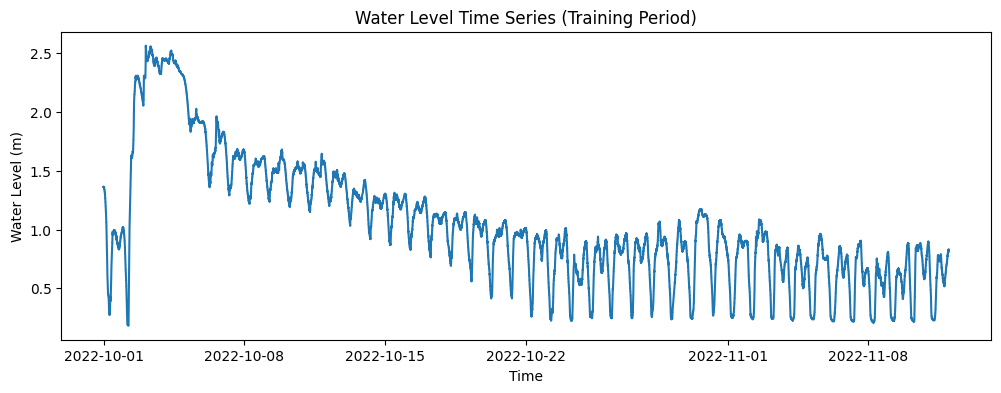

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df_train.index, df_train["WaterLevel(m)"])
plt.title("Water Level Time Series (Training Period)")
plt.xlabel("Time")
plt.ylabel("Water Level (m)")
plt.show()


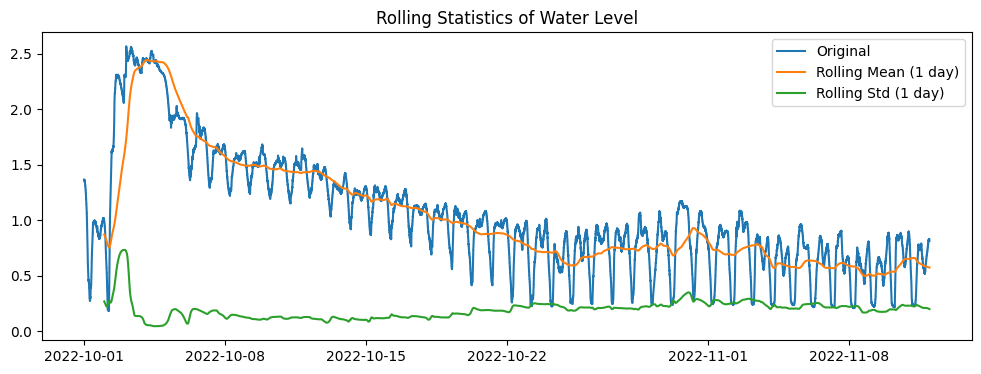

In [ ]:
rolling_mean = df_train["WaterLevel(m)"].rolling(1440).mean()
rolling_std = df_train["WaterLevel(m)"].rolling(1440).std()

plt.figure(figsize=(12,4))
plt.plot(df_train["WaterLevel(m)"], label="Original")
plt.plot(rolling_mean, label="Rolling Mean (1 day)")
plt.plot(rolling_std, label="Rolling Std (1 day)")
plt.legend()
plt.title("Rolling Statistics of Water Level")
plt.show()


In [ ]:
adf_result = adfuller(df_train["WaterLevel(m)"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -5.04287541635036
p-value: 1.82418972240589e-05


<Figure size 1200x400 with 0 Axes>

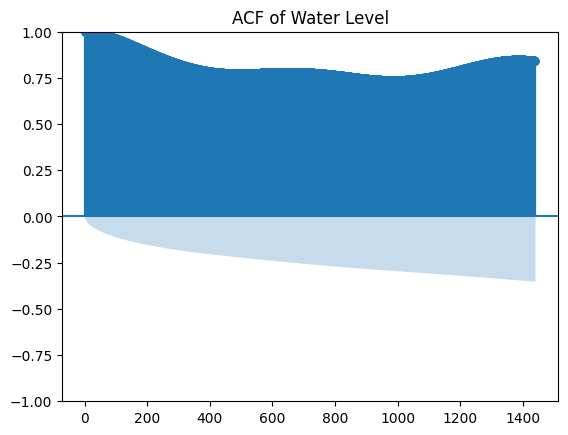

<Figure size 1200x400 with 0 Axes>

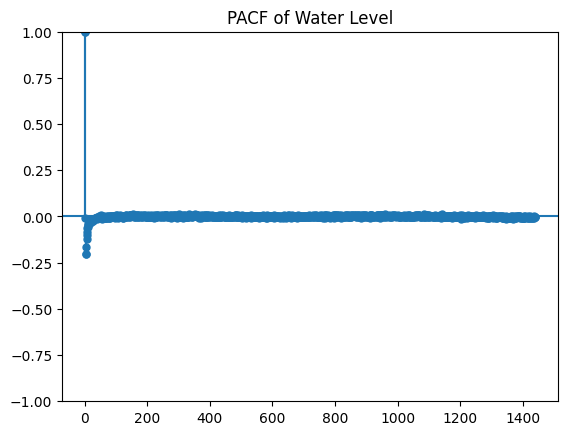

In [ ]:
plt.figure(figsize=(12,4))
plot_acf(df_train["WaterLevel(m)"], lags=1440)
plt.title("ACF of Water Level")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df_train["WaterLevel(m)"], lags=1440)
plt.title("PACF of Water Level")
plt.show()


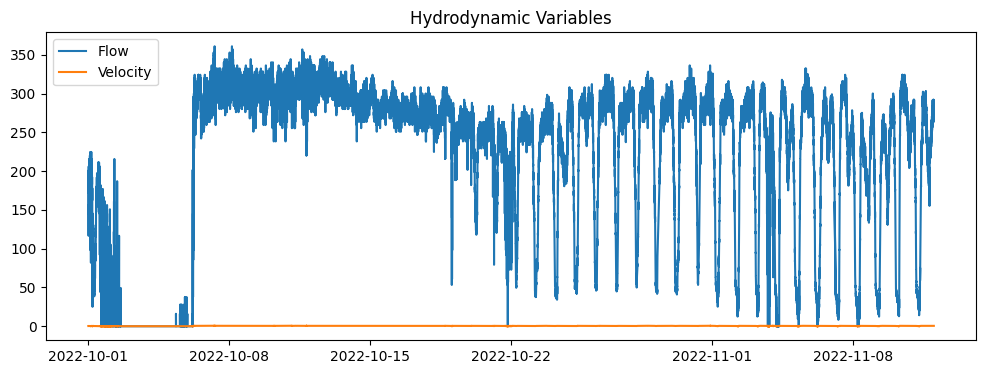

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df_train["Flow(L/s)"], label="Flow")
plt.plot(df_train["Velocity(m/s)"], label="Velocity")
plt.legend()
plt.title("Hydrodynamic Variables")
plt.show()


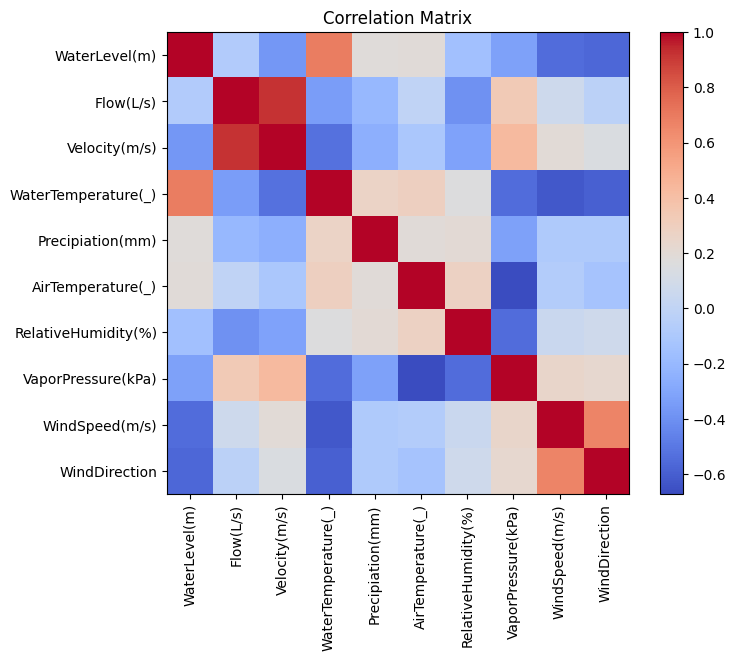

In [ ]:
corr = df_train.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix")
plt.show()


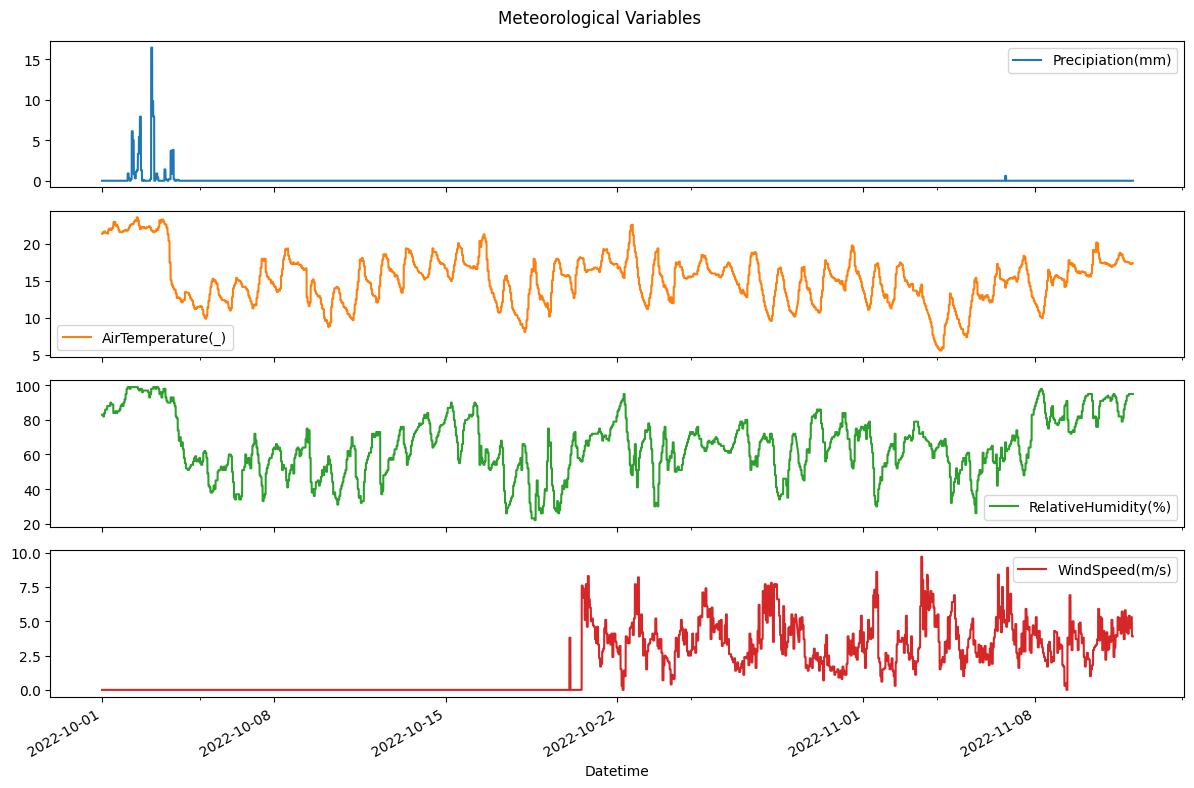

In [ ]:
met_cols = [
    "Precipiation(mm)",
    "AirTemperature(_)",
    "RelativeHumidity(%)",
    "WindSpeed(m/s)"
]

df_train[met_cols].plot(
    subplots=True,
    figsize=(12,8),
    title="Meteorological Variables"
)
plt.tight_layout()
plt.show()


In [ ]:
# 滞后相关（以 Flow 为例）
df_lag = df_train[["WaterLevel(m)", "Flow(L/s)"]].copy()
df_lag["Flow_lag_60"] = df_lag["Flow(L/s)"].shift(60)

df_lag.dropna(inplace=True)

df_lag.corr()


,WaterLevel(m),Flow(L/s),Flow_lag_60
WaterLevel(m),1.000000,-0.074017,-0.097273
Flow(L/s),-0.074017,1.000000,0.939419
Flow_lag_60,-0.097273,0.939419,1.000000


训练期: 2022-10-01 00:00:00 -> 2022-11-11 23:59:00
预测期: 2022-11-11 00:00:00 -> 2022-12-01 23:59:00


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/stat

SARIMAX(Fourier) 训练时间(s): 231.57201372500003
SARIMAX(Fourier) 预测时间(s): 0.6872023590000254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3461
[LightGBM] [Info] Number of data points in the train set: 57754, number of used features: 22
[LightGBM] [Info] Start training from score 1.038232
LightGBM 训练时间(s): 11.592155655999932
LightGBM 预测时间(s): 232.36917167199988

=== 模型对比 ===
SARIMAX(Fourier): {'MAE': 0.4800618730987215, 'RMSE': np.float64(0.5375958058368654)}
LightGBM: {'MAE': 0.38454731124238273, 'RMSE': np.float64(0.45812050036475466)}


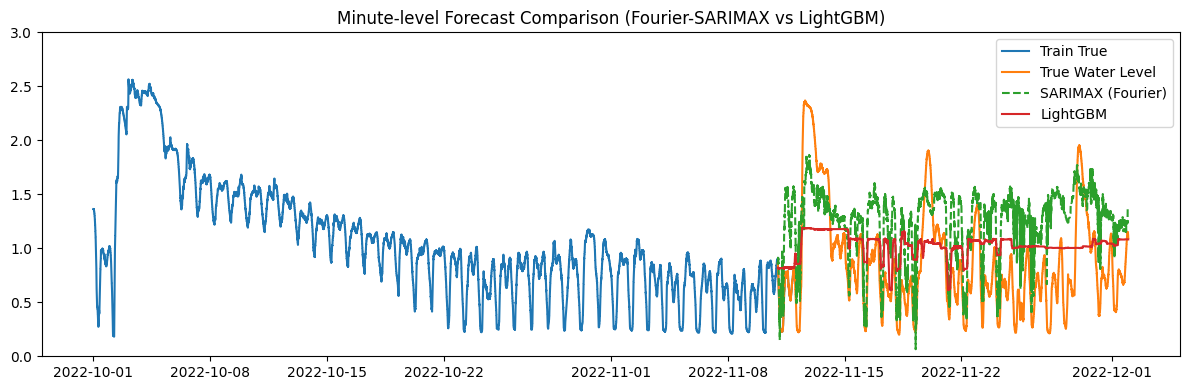

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
!pip install lightgbm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor



#1. 读入数据

df_train = pd.read_csv("df_train.csv", index_col=0, parse_dates=True)
df_forecast = pd.read_csv("df_forecast.csv", index_col=0, parse_dates=True)

df_train = df_train.sort_index()
df_forecast = df_forecast.sort_index()

TARGET = "WaterLevel(m)"

EXOG_COLS = [
    "Flow(L/s)",
    "Velocity(m/s)",
    "Precipiation(mm)",
    "AirTemperature(_)",
    "RelativeHumidity(%)",
    "VaporPressure(kPa)",
    "WindSpeed(m/s)",
    "WindDirection",
    "WaterTemperature(_)"
]
EXOG_COLS = [c for c in EXOG_COLS if c in df_train.columns]

print("训练期:", df_train.index.min(), "->", df_train.index.max())
print("预测期:", df_forecast.index.min(), "->", df_forecast.index.max())



#2. Fourier 特征（分钟级日周期）

def add_daily_fourier(df, period=1440, K=2):
    """
    分钟级日周期 Fourier 特征
    """
    df = df.copy()
    t = np.arange(len(df))
    for k in range(1, K + 1):
        df[f"sin_{k}"] = np.sin(2 * np.pi * k * t / period)
        df[f"cos_{k}"] = np.cos(2 * np.pi * k * t / period)
    return df

df_train_f = add_daily_fourier(df_train, period=1440, K=2)
df_forecast_f = add_daily_fourier(df_forecast, period=1440, K=2)

FOURIER_COLS = [c for c in df_train_f.columns if c.startswith("sin_") or c.startswith("cos_")]
EXOG_F = EXOG_COLS + FOURIER_COLS



#3. SARIMAX（Fourier-SARIMA，分钟级）

t0 = time.perf_counter()

sarimax_model = SARIMAX(
    df_train_f[TARGET],
    exog=df_train_f[EXOG_F],
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),   # ✅ 不用 1440 季节项
    enforce_stationarity=True,
    enforce_invertibility=True
)

sarimax_res = sarimax_model.fit(disp=False)
sarimax_train_time = time.perf_counter() - t0

# 未来预测
t0 = time.perf_counter()

sarimax_fc = sarimax_res.get_forecast(
    steps=len(df_forecast_f),
    exog=df_forecast_f[EXOG_F]
)

sarimax_pred = sarimax_fc.predicted_mean
sarimax_ci = sarimax_fc.conf_int()
sarimax_pred_time = time.perf_counter() - t0

print("SARIMAX(Fourier) 训练时间(s):", sarimax_train_time)
print("SARIMAX(Fourier) 预测时间(s):", sarimax_pred_time)



#4. LightGBM

def make_lgb_train_features(
    df,
    exog_cols,
    lags=(1, 5, 10, 30, 60),
    rolls=(60, 1440)
):
    data = df.copy()

    data["hour"] = data.index.hour
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month

    for L in lags:
        data[f"{TARGET}_lag_{L}"] = data[TARGET].shift(L)

    for w in rolls:
        data[f"{TARGET}_roll_mean_{w}"] = data[TARGET].shift(1).rolling(w).mean()
        data[f"{TARGET}_roll_std_{w}"] = data[TARGET].shift(1).rolling(w).std()

    feature_cols = (
        exog_cols
        + ["hour", "dayofweek", "day", "month"]
        + [c for c in data.columns if c.startswith(f"{TARGET}_lag_")]
        + [c for c in data.columns if c.startswith(f"{TARGET}_roll_")]
    )

    data = data.dropna()
    return data[feature_cols], data[TARGET], feature_cols


X_lgb, y_lgb, FEAT_COLS = make_lgb_train_features(df_train, EXOG_COLS)

lgb_model = LGBMRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

t0 = time.perf_counter()
lgb_model.fit(X_lgb, y_lgb)
print("LightGBM 训练时间(s):", time.perf_counter() - t0)



# 5. LightGBM 递推预测

def lgb_recursive_forecast(
    model,
    df_hist,
    df_future,
    exog_cols,
    feat_cols,
    lags=(1, 5, 10, 30, 60)
):
    history = df_hist[[TARGET]].copy()
    preds = []

    for t in df_future.index:
        row = {c: df_future.loc[t, c] for c in exog_cols}
        row.update({
            "hour": t.hour,
            "dayofweek": t.dayofweek,
            "day": t.day,
            "month": t.month
        })
        for L in lags:
            row[f"{TARGET}_lag_{L}"] = history[TARGET].iloc[-L]
        for c in feat_cols:
            if c not in row:
                row[c] = 0.0
        y_hat = model.predict(pd.DataFrame([row])[feat_cols])[0]
        preds.append(y_hat)
        history.loc[t, TARGET] = y_hat

    return pd.Series(preds, index=df_future.index, name="LGB_forecast")


df_future_for_pred = df_forecast.copy()
df_future_for_pred[TARGET] = np.nan

t0 = time.perf_counter()
lgb_pred = lgb_recursive_forecast(
    lgb_model,
    df_train[[TARGET] + EXOG_COLS],
    df_future_for_pred,
    EXOG_COLS,
    FEAT_COLS
)
print("LightGBM 预测时间(s):", time.perf_counter() - t0)



# 6. 统一评估 & 可视化

y_true = df_forecast[TARGET]

def metrics(y, yhat):
    return {
        "MAE": mean_absolute_error(y, yhat),
        "RMSE": np.sqrt(mean_squared_error(y, yhat))
    }

print("\n=== 模型对比 ===")
print("SARIMAX(Fourier):", metrics(y_true, sarimax_pred))
print("LightGBM:", metrics(y_true, lgb_pred))


plt.figure(figsize=(12,4))
plt.plot(df_train.index, df_train[TARGET], label="Train True")
plt.plot(df_forecast.index, df_forecast[TARGET], label="True Water Level")
plt.plot(df_forecast.index, sarimax_pred, label="SARIMAX (Fourier)", linestyle="--")
plt.plot(df_forecast.index, lgb_pred, label="LightGBM")
plt.ylim(0, 3)
plt.legend()
plt.title("Minute-level Forecast Comparison (Fourier-SARIMAX vs LightGBM)")
plt.tight_layout()
plt.show()


In [ ]:
def prediction_volatility(y_pred):
    return np.std(np.diff(y_pred))

sarimax_vol = prediction_volatility(sarimax_pred)
lgb_vol = prediction_volatility(lgb_pred)

print("SARIMAX 波动率:", sarimax_vol)
print("LightGBM 波动率:", lgb_vol)


SARIMAX 波动率: 0.024579189099005132
LightGBM 波动率: 0.0012148647286942197


In [ ]:
def spike_ratio(y_pred, k=3):
    diff = np.abs(np.diff(y_pred))
    return np.mean(diff > k * np.std(diff))

print("SARIMAX Spike Ratio:", spike_ratio(sarimax_pred))
print("LightGBM Spike Ratio:", spike_ratio(lgb_pred))


SARIMAX Spike Ratio: 0.026152971472526
LightGBM Spike Ratio: 0.04220594628942176


In [ ]:
def mean_drift(y_true, y_pred):
    return abs(np.mean(y_pred) - np.mean(y_true))

print("SARIMAX Drift:", mean_drift(y_true, sarimax_pred))
print("LightGBM Drift:", mean_drift(y_true, lgb_pred))


SARIMAX Drift: 0.3846726307820134
LightGBM Drift: 0.15845949957151073
